In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [11]:
data = pd.read_csv("/Users/yecortez/Downloads/credit_card_transactions.csv",
                   parse_dates=["trans_date_trans_time"],
                   dayfirst=False,
                  )

In [13]:
data['Date'] = pd.to_datetime(data['trans_date_trans_time'])

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype         
---  ------  --------------    -----         
 0   Date    1296675 non-null  datetime64[ns]
 1   amt     1296675 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.8 MB


In [14]:
data = data[["Date","amt"]]

In [15]:
data_daily = data.resample('D', on='Date').agg({'amt': 'sum'}).reset_index()

In [16]:
data_daily.set_index('Date', inplace=True)

In [17]:
data_daily

,amt
Date,
2019-01-01,156487.09
2019-01-02,70723.58
2019-01-03,86516.49
2019-01-04,112436.39
2019-01-05,97496.13
...,...
2020-06-17,141792.48
2020-06-18,166713.71
2020-06-19,176152.74


In [21]:
data_daily.index = pd.to_datetime(data_daily.index)

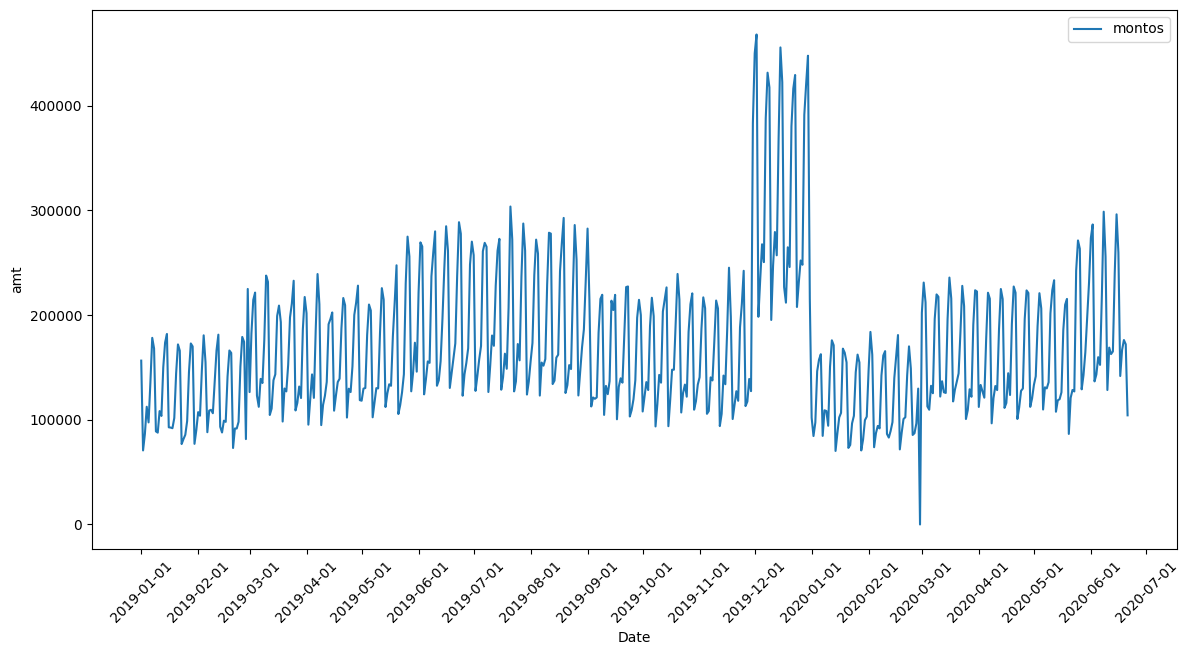

In [25]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(14, 7))
plt.plot(data_daily.index, data_daily["amt"], label='montos')

# Formatear el eje X para que muestre fechas legibles
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Formato Año-Mes-Día
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Mostrar cada mes

plt.xlabel('Date')
plt.ylabel('amt')
plt.legend()
plt.xticks(rotation=45)  # Rotar etiquetas de fechas para mejor visualización
plt.show()


In [26]:
# Perform the Augmented Dickey-Fuller test on the original series
result_original = adfuller(data_daily["amt"])

print(f"ADF Statistic (Original): {result_original[0]:.4f}")
print(f"p-value (Original): {result_original[1]:.4f}")

if result_original[1] < 0.05:
    print("Interpretation: The original series is Stationary.\n")
else:
    print("Interpretation: The original series is Non-Stationary.\n")

# Apply first-order differencing
data_daily['amt_Diff'] = data_daily['amt'].diff()

# Perform the Augmented Dickey-Fuller test on the differenced series
result_diff = adfuller(data_daily["amt_Diff"].dropna())
print(f"ADF Statistic (Differenced): {result_diff[0]:.4f}")
print(f"p-value (Differenced): {result_diff[1]:.4f}")
if result_diff[1] < 0.05:
    print("Interpretation: The differenced series is Stationary.")
else:
    print("Interpretation: The differenced series is Non-Stationary.")


ADF Statistic (Original): -3.5052
p-value (Original): 0.0079
Interpretation: The original series is Stationary.

ADF Statistic (Differenced): -5.8504
p-value (Differenced): 0.0000
Interpretation: The differenced series is Stationary.


Como es estacionaria, no hay que hacer la diferencia

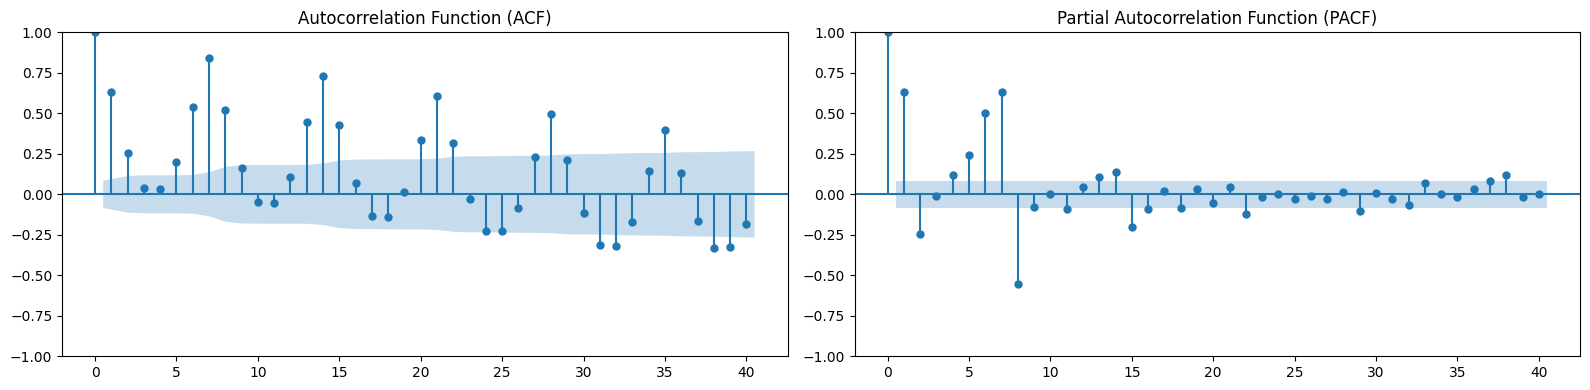

In [47]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Plot ACF and PACF for the differenced series
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

# ACF plot
plot_acf(data_daily['amt'].dropna(), lags=40, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')

# PACF plot
plot_pacf(data_daily['amt'].dropna(), lags=40, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

In [53]:
# Split data into train and test
train_size = int(len(data_daily) * 0.8)
train, test = data_daily.iloc[:train_size], data_daily.iloc[train_size:]

# Fit ARIMA model
model = ARIMA(train["amt"], order=(1,0,0))
model_fit = model.fit()

/Users/yecortez/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/yecortez/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/yecortez/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


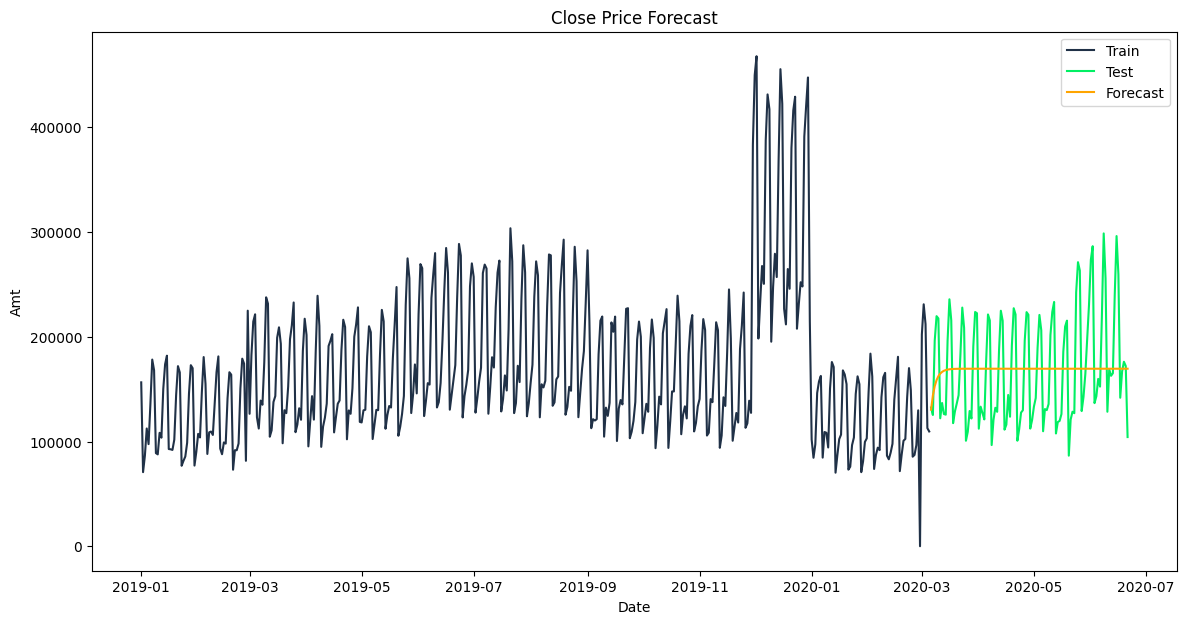

In [55]:
# Forecast
forecast = model_fit.forecast(steps=len(test))

# Plot the results with specified colors
plt.figure(figsize=(14,7))
plt.plot(train.index, train["amt"], label='Train', color='#203147')
plt.plot(test.index, test["amt"], label='Test', color='#01ef63')
plt.plot(test.index, forecast, label='Forecast', color='orange')
plt.title('Close Price Forecast')
plt.xlabel('Date')
plt.ylabel('Amt')
plt.legend()
plt.show()


In [56]:
print(f"AIC: {model_fit.aic}")
print(f"BIC: {model_fit.bic}")

AIC: 10616.15221510002
BIC: 10628.343570726083


In [57]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Asegurar que forecast y test_close tengan la misma longitud
forecast = forecast[:len(test)]
test_close = test["amt"][:len(forecast)]

# Calcular RMSE
rmse = np.sqrt(mean_squared_error(test_close, forecast))

# Calcular R²
r2 = r2_score(test_close, forecast)

print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")


RMSE: 51922.2029
R²: 0.0021
